<a href="https://colab.research.google.com/github/mgdante/nn-testing/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from shutil import rmtree
from os.path import isdir
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from sklearn.model_selection import train_test_split
import capslayer as cl

In [11]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
(x_train, y_train_raw), (x_test, y_test_raw) = tf.keras.datasets.cifar10.load_data()
# y_train_raw = [x[0] for x in y_train_raw]

In [3]:
y_train_raw.shape

(50000, 1)

In [4]:
# x_train = tf.reshape(x_train_raw, [-1, 32, 32, 3]).numpy()
y_train_raw = tf.reshape(y_train_raw, [-1])
y_train = tf.one_hot(y_train_raw, 10).numpy()
# x_test = tf.reshape(x_test_raw, [-1, 32, 32, 3]).numpy()
y_test_raw = tf.reshape(y_test_raw, [-1])
y_test = tf.one_hot(y_test_raw, 10).numpy()

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

In [6]:
model = None
model = Sequential()

model.add(preprocessing.Resizing(32, 32))
model.add(preprocessing.Rescaling(1./255))

model.add(preprocessing.RandomFlip('horizontal'))
model.add(preprocessing.RandomRotation(0.10))
model.add(preprocessing.RandomContrast(0.10))
model.add(preprocessing.RandomZoom(0.10, 0.10))
# LeakyReLU()
act = LeakyReLU()
model.add(Conv2D(128, 7, activation=act, input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(128, 5, activation=act, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), padding='same'))
# model.add(Dropout(0.05))

model.add(Conv2D(128, 3, activation=act, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(256, act))
model.add(BatchNormalization())
model.add(Dense(128, act))
model.add(BatchNormalization())
model.add(Dense(64, act))
model.add(BatchNormalization())
# model.add(Dropout(0.20))

model.add(Dense(10, 'softmax'))

model.compile(tf.keras.optimizers.Adam(), tf.keras.losses.CategoricalCrossentropy(), 'accuracy')
model.build(input_shape=(1, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (1, 32, 32, 3)            0         
_________________________________________________________________
rescaling (Rescaling)        (1, 32, 32, 3)            0         
_________________________________________________________________
random_flip (RandomFlip)     (1, 32, 32, 3)            0         
_________________________________________________________________
random_rotation (RandomRotat (1, 32, 32, 3)            0         
_________________________________________________________________
random_contrast (RandomContr (1, 32, 32, 3)            0         
_________________________________________________________________
random_zoom (RandomZoom)     (1, 32, 32, 3)            0         
_________________________________________________________________
conv2d (Conv2D)              (1, 32, 32, 128)          1

In [7]:
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', min_delta=0.002, factor=0.6, patience=2) #0.001
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.002, patience=3, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [8]:
from time import sleep

if isdir('./logs'):
    rmtree('./logs')
    sleep(2)
    if isdir('./logs'):
        print('TB LOGS DELETED')
    elif isdir('./logs'):
        print('RETRYING...')
        rmtree('./logs')
        sleep(2)
        if isdir('./logs'):
            print('TB LOGS DELETED')
        else:
            print('DELETE FAILED')
else:
    print('TB LOGS DOES NOT EXIST')
tbcb = tf.keras.callbacks.TensorBoard()

TB LOGS DOES NOT EXIST


In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 16 05:55:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P520        WDDM  | 00000000:6C:00.0 Off |                  N/A |
| N/A   50C    P0    N/A /  N/A |   2992MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model.load_weights('./cifar10')

In [11]:
model_train = model.fit(x_train, y_train, 256, 100, 1, callbacks=[learning_rate, early_stop, tbcb], validation_data=(x_valid, y_valid)).history
model.save_weights('./cifar10')

Epoch 1/100
176/176 [==============================] - 56s 246ms/step - loss: 1.5364 - accuracy: 0.4527 - val_loss: 4.2318 - val_accuracy: 0.1308
Epoch 2/100
176/176 [==============================] - 41s 233ms/step - loss: 1.2618 - accuracy: 0.5543 - val_loss: 2.6504 - val_accuracy: 0.2500
Epoch 3/100
172/176 [============================>.] - ETA: 0s - loss: 1.1341 - accuracy: 0.5961

KeyboardInterrupt: 

In [9]:
model.evaluate(x_test, y_test)

NameError: name 'model' is not defined

(7, 7, 3, 128)
(5, 5, 128, 128)
(3, 3, 128, 128)


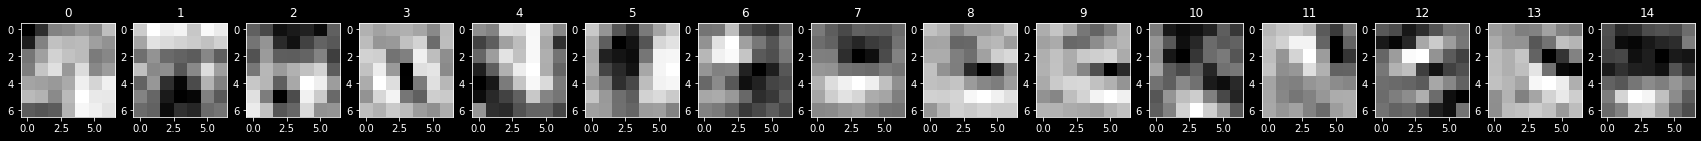

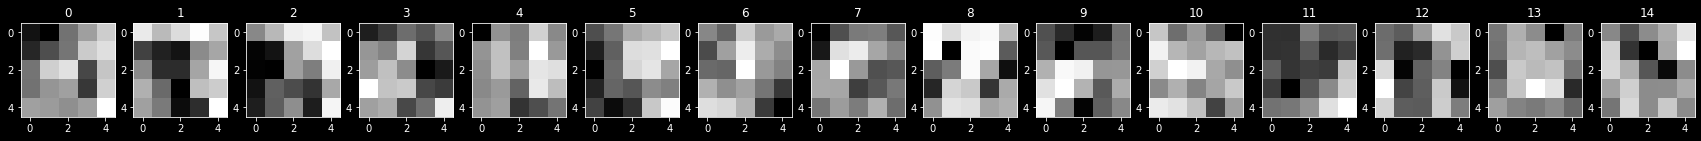

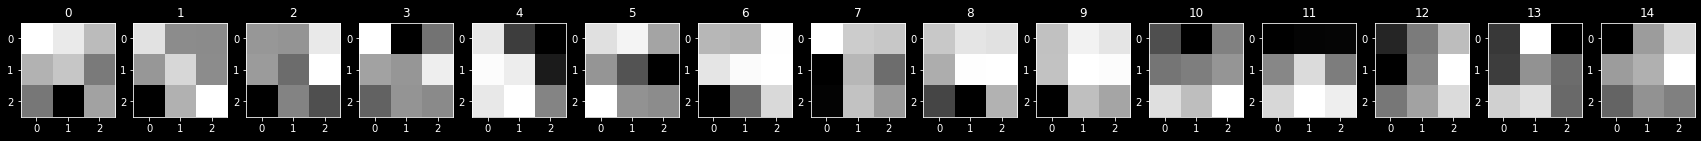

In [15]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        print(W.shape)
        if len(W.shape) == 4:
            W = W.reshape(W.shape[0], W.shape[1], W.shape[2] * W.shape[3]) 
        else:
            W = W.reshape(W.shape[0], W.shape[1], W.shape[2]) 
        fig, axs = plt.subplots(1,15, figsize=(30,30))
        # fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(15):
            axs[i].imshow(W[:,:,i], cmap='Greys_r')
            axs[i].set_title(str(i))

for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    else:
        plot_conv_weights(model, layer.name)

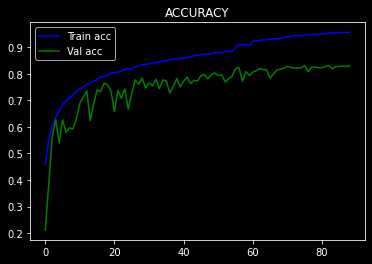

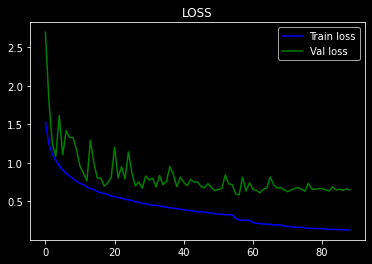

<Figure size 432x288 with 0 Axes>

In [16]:
acc = model_train['accuracy']
val_acc = model_train['val_accuracy']
loss = model_train['loss']
val_loss = model_train['val_loss']
epoch_count = range(len(acc))

plt.plot(epoch_count, acc, 'b', label='Train acc')
plt.plot(epoch_count, val_acc, 'g', label='Val acc')
plt.title('ACCURACY')
plt.legend()
plt.figure()

plt.plot(epoch_count, loss, 'b', label='Train loss')
plt.plot(epoch_count, val_loss, 'g', label='Val loss')
plt.title('LOSS')
plt.legend()
plt.figure()

plt.show()